## Resnet

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Plain Networks

#### Conv block

In [4]:
def conv_batch(layer, channel, kernel_size, padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

#### Plain block

In [5]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x


#### Build plain network

In [6]:
def build_plain(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model

### Plain-34

In [7]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

### Plain-50

In [8]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

### Resnet

#### Residual block

In [9]:
def build_residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

#### Build ResNet

In [10]:
def build_resnet(num_cnn_list, channel_list, is_50=True, cats_vs_dogs=False, input_shape=(32,32,3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
    res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    if cats_vs_dogs:
        output = keras.layers.Dense(1, activation='sigmoid',kernel_initializer='he_normal', name='FC')(gap)
    else:
        output = keras.layers.Dense(num_classes, activation='softmax',kernel_initializer='he_normal', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

### ResNet-34

In [11]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

### ResNet-50

In [12]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

### ResNet-34 vs ResNet-50 vs Plain-34 vs Plain-50

#### Dataset (cats_and_dog)

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [14]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [15]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [16]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224,224)) # resize
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [17]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

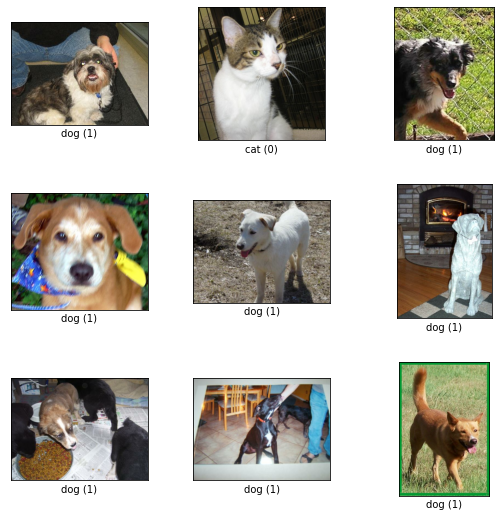

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

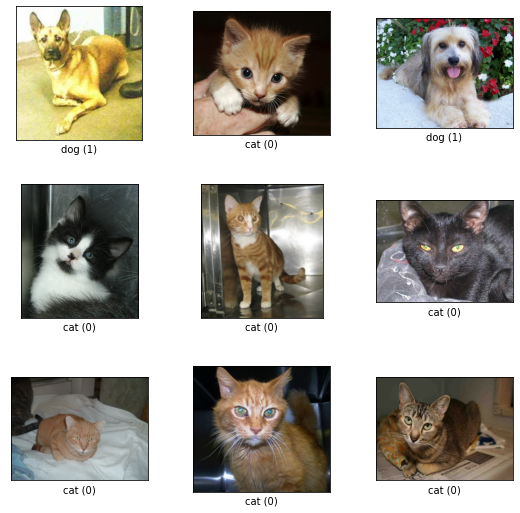

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

### Train

In [20]:
BATCH_SIZE = 32 #256
iteration = 15000 #600000
EPOCH = iteration*BATCH_SIZE//int(ds_info.splits['train'].num_examples)

In [21]:
EPOCH

20

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [23]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(lr)
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(lr)
    return lr

In [24]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, monitor='val_loss', patience=1, verbose=2, min_lr=1e-6)

In [25]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3),
                         name='ResNet_34')

In [26]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 99s 151ms/step - loss: 2.2879 - accuracy: 0.5544 - val_loss: 2.0202 - val_accuracy: 0.6064 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 113s 172ms/step - loss: 1.8493 - accuracy: 0.6292 - val_loss: 1.9582 - val_accuracy: 0.5391 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 88s 135ms/step - loss: 1.5263 - accuracy: 0.6875 - val_loss: 1.6356 - val_accuracy: 0.5903 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 90s 137ms/step - loss: 1.2846 - accuracy: 0.7178 - val_loss: 1.3418 - val_accuracy: 0.6050 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 88s 135ms/step - loss: 1.1022 - accuracy: 0.7436 - val_loss: 1.2617 - val_accuracy: 0.6029 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - 88s 134ms/step - loss: 0.9557 - accuracy: 0.7629 - val_loss: 1.1741 - val_accuracy: 0.6003 - lr: 0.1000
Epoch 7/20
654/654 [==============================]

In [27]:
del resnet_34

In [28]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         cats_vs_dogs=True,
                         input_shape=(224,224,3))

In [29]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 176s 269ms/step - loss: 5.6572 - accuracy: 0.5449 - val_loss: 4.8942 - val_accuracy: 0.5919 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 65s 100ms/step - loss: 4.3679 - accuracy: 0.6323 - val_loss: 4.0908 - val_accuracy: 0.5552 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 65s 100ms/step - loss: 3.4649 - accuracy: 0.6874 - val_loss: 3.1898 - val_accuracy: 0.5753 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 65s 100ms/step - loss: 2.7712 - accuracy: 0.7213 - val_loss: 2.5678 - val_accuracy: 0.6684 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 66s 100ms/step - loss: 2.2319 - accuracy: 0.7604 - val_loss: 2.0587 - val_accuracy: 0.7255 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - 66s 101ms/step - loss: 1.8074 - accuracy: 0.7940 - val_loss: 1.9255 - val_accuracy: 0.6905 - lr: 0.1000
Epoch 7/20
654/654 [==============================]

In [30]:
del resnet_50

In [31]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3),
                       name='Plain_34')

In [32]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 84s 128ms/step - loss: 2.0841 - accuracy: 0.5308 - val_loss: 1.8899 - val_accuracy: 0.5573 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 83s 127ms/step - loss: 1.7345 - accuracy: 0.5904 - val_loss: 1.5841 - val_accuracy: 0.6246 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 84s 128ms/step - loss: 1.4828 - accuracy: 0.6109 - val_loss: 1.3795 - val_accuracy: 0.6207 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - ETA: 0s - loss: 1.2842 - accuracy: 0.6325
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
654/654 [==============================] - 84s 128ms/step - loss: 1.2842 - accuracy: 0.6325 - val_loss: 1.4243 - val_accuracy: 0.5066 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 85s 130ms/step - loss: 1.1679 - accuracy: 0.6638 - val_loss: 1.1643 - val_accuracy: 0.6641 - lr: 0.0100
Epoch 6/20
654/654 [==========================

In [33]:
del plain_34

In [34]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       cats_vs_dogs=True,
                       input_shape=(224,224,3))

In [35]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/20
654/654 [==============================] - 154s 235ms/step - loss: 4.8273 - accuracy: 0.5017 - val_loss: 4.2696 - val_accuracy: 0.5096 - lr: 0.1000
Epoch 2/20
654/654 [==============================] - 189s 288ms/step - loss: 3.8396 - accuracy: 0.5168 - val_loss: 3.4384 - val_accuracy: 0.5473 - lr: 0.1000
Epoch 3/20
654/654 [==============================] - 129s 198ms/step - loss: 3.1151 - accuracy: 0.5283 - val_loss: 2.8058 - val_accuracy: 0.5608 - lr: 0.1000
Epoch 4/20
654/654 [==============================] - 130s 198ms/step - loss: 2.5560 - accuracy: 0.5413 - val_loss: 2.3342 - val_accuracy: 0.5035 - lr: 0.1000
Epoch 5/20
654/654 [==============================] - 130s 198ms/step - loss: 2.1215 - accuracy: 0.5641 - val_loss: 1.9399 - val_accuracy: 0.5687 - lr: 0.1000
Epoch 6/20
654/654 [==============================] - 130s 198ms/step - loss: 1.7950 - accuracy: 0.5570 - val_loss: 1.6652 - val_accuracy: 0.5447 - lr: 0.1000
Epoch 7/20
654/654 [==========================

In [36]:
del plain_50

### Comparison

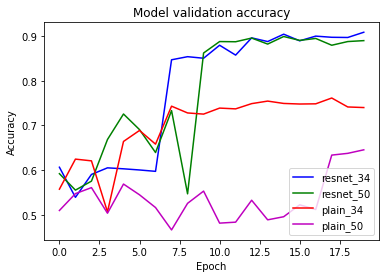

In [37]:
plt.plot(history_34.history['val_accuracy'], 'b')
plt.plot(history_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

### 느낀점(회고)

ResNet-34 와 ResNet-50을 구현하여, Plain-34, Plain-50과 비교해봤습니다.
데이터는 cats_vs_dogs 데이터를 사용했습니다.